In [85]:
import os
import torch
import numpy as np

import torchvision.transforms as transforms
from datasets import *
from models import *
from displays import *

## Loading and Preparing Dataset

### Parameters and Settings

In [86]:
IMG_HEI, IMG_WID = 160, 320
N_CLASSES = 34

In [87]:
toCuda = lambda x: x.cuda()
G = [
    toCuda,
    #transforms.RandomRotation(degrees=35, 
    #                          interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomResizedCrop(size=(IMG_HEI, IMG_WID), scale=(.2, 1), ratio=(4/5,5/4), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(p=0.5),
]
G = transforms.Compose(G)
traintest_transforms = get_transforms2(
    [
        G
    ], [
        transforms.Resize((IMG_HEI, IMG_WID), 
                          interpolation=transforms.InterpolationMode.NEAREST),
    ],
    [
        G,
        #transforms.ColorJitter(brightness=(.5,1.5),contrast=(.8,1.5),saturation=(.5,1.5),hue=(-.1,.1))
    ], [
        transforms.Resize((IMG_HEI, IMG_WID), 
                          interpolation=transforms.InterpolationMode.NEAREST),
    ]
    , n_classes=N_CLASSES, to_tensor=True)

### Functions

In [88]:
# Avoid changing the following code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [89]:
from torch.utils.data import DataLoader
from torchvision import datasets

# loading data
dataset = lambda root, train, download, transform, target_transform, **kwargs: \
    CityscapeDataset(
        datasets.Cityscapes(
            root=os.path.join(root, 'cityscapes'), 
            split='train' if train else 'val',
            mode='fine',
            target_type='semantic', 
            **kwargs
        ),
        img_transform=transform,
        targ_transform=target_transform
    )

In [90]:
train_data, val_data = fetch_dataset2(dataset, *traintest_transforms)
train_loader, val_loader = get_dataloader(train_data, val_data, batch_size=16)

### Parameters and Setttings

In [91]:

epoch = 0

LOAD_PATH = None
COMBINE_TRAIN = False
INNER_LOG_DISPLAY = True

In [120]:
#LOAD_PATH = "models/1710510388/249/model_1710744043.h5"
LOAD_PATH = None

In [119]:
# User can set these parameters
batch_size = 128#64

#INITIAL_LR = 1e-4
INITIAL_LR = 5e-5
#GAMMA = .995
GAMMA = .99
#GAMMA = .975

OPTIMIZER = torch.optim.Adam
DECAY_METHOD = torch.optim.lr_scheduler.ExponentialLR

NUM_EPOCHS = 100
NUM_EPOCHS_TO_SAVE = 10

In [94]:
model = UNet(in_channels=3, out_channels=N_CLASSES).to(device)

### Functions

In [95]:
import time
TRAIN_ID = int(time.time())

In [96]:
training_losses = []
validation_losses = []
training_accuracy = []
validation_accuracy = []
training_ious = []
validation_ious = []
lrs = []

In [97]:
# Avoid changing the following code
from torch.utils.data import DataLoader, ConcatDataset
from libs import *

In [98]:
import importlib
import libs
importlib.reload(libs)

<module 'libs' from 'c:\\kht\\ai\\AI Projects (Local)\\proj vision transformer\\libs.py'>

### Training
Start here to continue training.

In [127]:
load_model(model, LOAD_PATH, device=device)
loss_fn, opt, scheduler = set_optimizers(model, loss_fn=nn.CrossEntropyLoss, optimizer=OPTIMIZER, lr=INITIAL_LR, decay=DECAY_METHOD, gamma=GAMMA)

In [128]:
def train_(epochs:int=100, inner_log:bool=False):
    global epoch
    
    if not inner_log:
        print('\n', "=" * 15, "Epoch", epoch + 1, "=" * 15)

    rng = tqdm(range(epochs)) if not inner_log else range(epochs)
    
    for t in rng:
        if inner_log:
            print('\n', "=" * 15, "Epoch", epoch + 1, "=" * 15)
        loss, train_accuracy, train_iou, lr = libs.train(train_loader, model, loss_fn, opt, scheduler=scheduler, device=device, log=inner_log)
        val_loss, val_accuracy, val_iou = libs.test(val_loader, model, loss_fn, device=device, log=inner_log)
        training_losses.append(loss)
        validation_losses.append(val_loss)
        training_accuracy.append(train_accuracy)
        validation_accuracy.append(val_accuracy)
        training_ious.append(train_iou)
        validation_ious.append(val_iou)
        lrs.append(lr)

        if epoch <= 5:
            imshow_test(model, val_loader, device, show_reference=False, show_original=False, colorbar=False, softmax=True)

        epoch += 1
    
    print(f" Train accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {loss:>8f}, lr: {lr}")
    print(f" Test accuracy: {(100*val_accuracy):>0.1f}%, Avg loss: {val_loss:>8f}")

In [129]:
def plot(PTH):
    plt.plot(training_accuracy, label=f'Train Accuracy\nLast: {training_accuracy[-1]}')
    plt.plot(validation_accuracy, label=f'Test Accuracy\nLast: {validation_accuracy[-1]}')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_accs.png')
    plt.show()

    plt.plot(training_losses, label=f'Train Loss\nLast: {training_losses[-1]}')
    plt.plot(validation_losses, label=f'Test Loss\nLast: {validation_losses[-1]}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_losses.png')
    plt.show()

    plt.plot(training_ious, label=f'Train IOUs\nLast: {training_ious[-1]}')
    plt.plot(validation_ious, label=f'Test IOUs\nLast: {validation_ious[-1]}')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_ious.png')
    plt.show()

    plt.plot(lrs, label=f'Lrs\nFinal: {lrs[-1]}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.savefig(f'{PTH}_lrs.png')
    plt.show()

Actual training

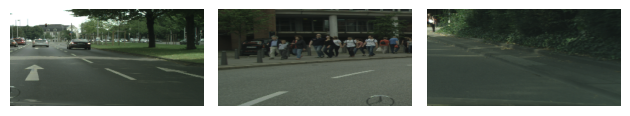

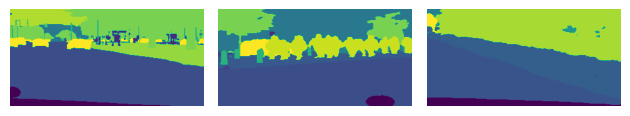

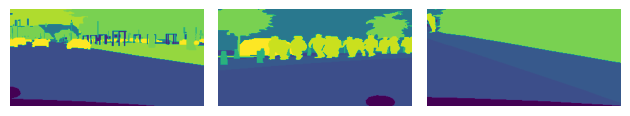

In [124]:
imshow_test(model, train_loader, device, show_reference=True, show_original=True, colorbar=False, softmax=True)

In [125]:
print(device)
libs.test(val_loader, model, loss_fn, device=device, log=True)

cuda


100%|██████████| 32/32 [01:02<00:00,  1.97s/it]

 Test accuracy: 87.50324845314026%, Avg loss: 0.5356328440830112, IOU: 39.578914642333984


(0.5356328440830112,
 array(0.8750325, dtype=float32),
 array(0.39578915, dtype=float32))


 =============== Epoch 676 ===============


100%|██████████| 186/186 [14:51<00:00,  4.79s/it]


 Train accuracy: 96.58217430114746%, Avg loss: 0.09666942612778756, IOU: 62.8312885761261 lr: 2.4520447035642858e-06


100%|██████████| 32/32 [01:08<00:00,  2.14s/it]


 Test accuracy: 88.01313638687134%, Avg loss: 0.5700900871306658, IOU: 41.03218615055084

 =============== Epoch 677 ===============


100%|██████████| 186/186 [14:47<00:00,  4.77s/it]


 Train accuracy: 96.58545255661011%, Avg loss: 0.09667689321182107, IOU: 62.94751763343811 lr: 2.427524256528643e-06


100%|██████████| 32/32 [01:10<00:00,  2.20s/it]


 Test accuracy: 87.9936158657074%, Avg loss: 0.5772484131157398, IOU: 40.87384641170502

 =============== Epoch 678 ===============


100%|██████████| 186/186 [14:53<00:00,  4.80s/it]


 Train accuracy: 96.59083485603333%, Avg loss: 0.09625762697028857, IOU: 63.03555965423584 lr: 2.4032490139633563e-06


100%|██████████| 32/32 [01:15<00:00,  2.37s/it]


 Test accuracy: 87.99262046813965%, Avg loss: 0.5751161705702543, IOU: 40.97702205181122

 =============== Epoch 679 ===============


100%|██████████| 186/186 [15:15<00:00,  4.92s/it]


 Train accuracy: 96.578848361969%, Avg loss: 0.09670575423746981, IOU: 62.5389039516449 lr: 2.379216523823723e-06


100%|██████████| 32/32 [01:09<00:00,  2.18s/it]


 Test accuracy: 87.95669078826904%, Avg loss: 0.5757651468738914, IOU: 40.93039333820343

 =============== Epoch 680 ===============


100%|██████████| 186/186 [15:08<00:00,  4.89s/it]


 Train accuracy: 96.59320712089539%, Avg loss: 0.09612376631427837, IOU: 62.90545463562012 lr: 2.3554243585854857e-06


100%|██████████| 32/32 [01:08<00:00,  2.15s/it]


 Test accuracy: 88.0502700805664%, Avg loss: 0.578799013979733, IOU: 41.1199152469635

 =============== Epoch 681 ===============


100%|██████████| 186/186 [15:45<00:00,  5.08s/it]


 Train accuracy: 96.5924084186554%, Avg loss: 0.0962646538692136, IOU: 62.704551219940186 lr: 2.331870114999631e-06


100%|██████████| 32/32 [01:12<00:00,  2.28s/it]


 Test accuracy: 88.04813623428345%, Avg loss: 0.5776103497482836, IOU: 41.08873903751373

 =============== Epoch 682 ===============


100%|██████████| 186/186 [15:19<00:00,  4.94s/it]


 Train accuracy: 96.57098054885864%, Avg loss: 0.09679270884202372, IOU: 62.75080442428589 lr: 2.3085514138496347e-06


100%|██████████| 32/32 [01:12<00:00,  2.26s/it]


 Test accuracy: 88.00942897796631%, Avg loss: 0.5767169785685837, IOU: 40.94404578208923

 =============== Epoch 683 ===============


100%|██████████| 186/186 [14:59<00:00,  4.84s/it]


 Train accuracy: 96.58722877502441%, Avg loss: 0.09654265005261667, IOU: 62.99031376838684 lr: 2.2854658997111384e-06


100%|██████████| 32/32 [01:12<00:00,  2.26s/it]


 Test accuracy: 88.07408213615417%, Avg loss: 0.5753456163220108, IOU: 41.08668267726898

 =============== Epoch 684 ===============


100%|██████████| 186/186 [15:05<00:00,  4.87s/it]


 Train accuracy: 96.58944606781006%, Avg loss: 0.09626587836812901, IOU: 62.52360939979553 lr: 2.262611240714027e-06


100%|██████████| 32/32 [01:10<00:00,  2.19s/it]


 Test accuracy: 88.03020119667053%, Avg loss: 0.5725059709511697, IOU: 40.963396430015564

 =============== Epoch 685 ===============


100%|██████████| 186/186 [14:14<00:00,  4.59s/it]


 Train accuracy: 96.60511612892151%, Avg loss: 0.0958694919783582, IOU: 62.88952827453613 lr: 2.239985128306887e-06


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


 Test accuracy: 88.0559504032135%, Avg loss: 0.5764489816501737, IOU: 41.083499789237976
 Train accuracy: 96.6%, Avg loss: 0.095869, lr: 2.239985128306887e-06
 Test accuracy: 88.1%, Avg loss: 0.576449


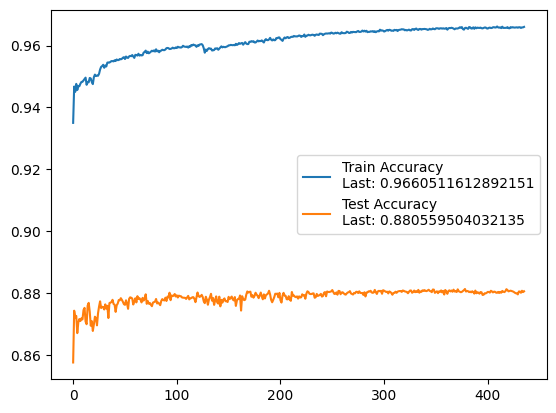

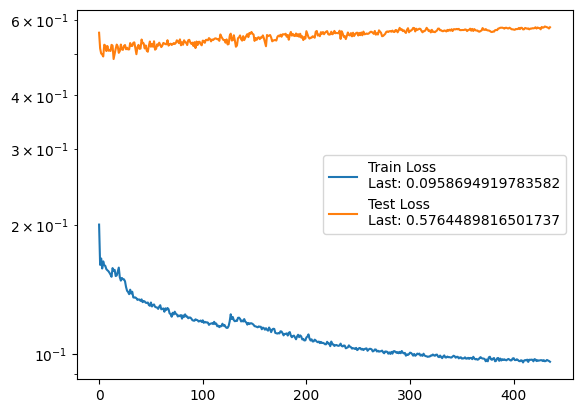

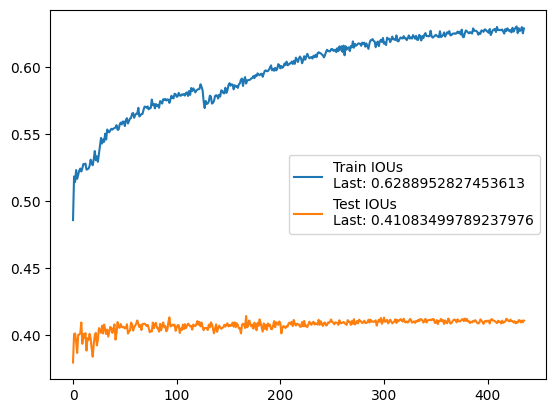

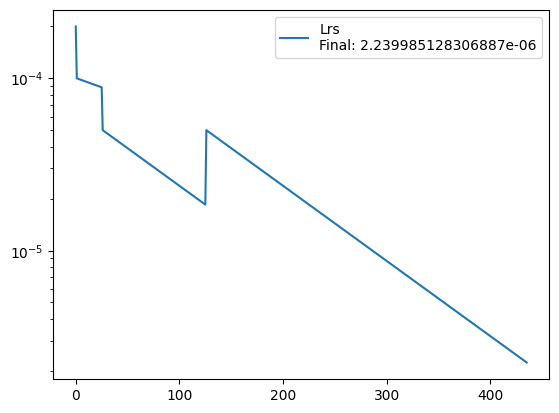

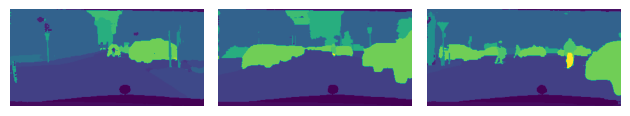


 =============== Epoch 686 ===============


100%|██████████| 186/186 [13:14<00:00,  4.27s/it]


 Train accuracy: 96.60454988479614%, Avg loss: 0.09576044952677142, IOU: 62.756162881851196 lr: 2.2175852770238177e-06


100%|██████████| 32/32 [00:57<00:00,  1.81s/it]


 Test accuracy: 88.06205987930298%, Avg loss: 0.5744584035128355, IOU: 41.11816883087158

 =============== Epoch 687 ===============


100%|██████████| 186/186 [13:31<00:00,  4.36s/it]


 Train accuracy: 96.58134579658508%, Avg loss: 0.09663495657745227, IOU: 62.87522912025452 lr: 2.1954094242535797e-06


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


 Test accuracy: 88.02985548973083%, Avg loss: 0.5748647633008659, IOU: 40.9747838973999

 =============== Epoch 688 ===============


100%|██████████| 186/186 [13:27<00:00,  4.34s/it]


 Train accuracy: 96.55128121376038%, Avg loss: 0.09753017904617453, IOU: 62.672823667526245 lr: 2.173455330011044e-06


100%|██████████| 32/32 [00:57<00:00,  1.80s/it]


 Test accuracy: 88.01926970481873%, Avg loss: 0.5774488672614098, IOU: 40.973737835884094

 =============== Epoch 689 ===============


100%|██████████| 186/186 [13:17<00:00,  4.29s/it]


 Train accuracy: 96.58483266830444%, Avg loss: 0.09644115828378226, IOU: 62.66144514083862 lr: 2.1517207767109334e-06


100%|██████████| 32/32 [00:59<00:00,  1.87s/it]


 Test accuracy: 88.05864453315735%, Avg loss: 0.5760741517879069, IOU: 41.046708822250366

 =============== Epoch 690 ===============


100%|██████████| 186/186 [13:26<00:00,  4.33s/it]


 Train accuracy: 96.58863544464111%, Avg loss: 0.09634993894286054, IOU: 62.716102600097656 lr: 2.130203568943824e-06


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


 Test accuracy: 88.00652623176575%, Avg loss: 0.5762842041440308, IOU: 40.98095893859863

 =============== Epoch 691 ===============


100%|██████████| 186/186 [13:27<00:00,  4.34s/it]


 Train accuracy: 96.59327864646912%, Avg loss: 0.09628518983241051, IOU: 62.676072120666504 lr: 2.108901533254386e-06


100%|██████████| 32/32 [01:00<00:00,  1.88s/it]


 Test accuracy: 88.07752728462219%, Avg loss: 0.5706364009529352, IOU: 41.07252657413483

 =============== Epoch 692 ===============


100%|██████████| 186/186 [13:26<00:00,  4.34s/it]


 Train accuracy: 96.58052921295166%, Avg loss: 0.09648852739282833, IOU: 62.74115443229675 lr: 2.0878125179218418e-06


100%|██████████| 32/32 [01:01<00:00,  1.91s/it]


 Test accuracy: 88.10895085334778%, Avg loss: 0.5704380283132195, IOU: 41.146621108055115

 =============== Epoch 693 ===============


100%|██████████| 186/186 [13:19<00:00,  4.30s/it]


 Train accuracy: 96.62052989006042%, Avg loss: 0.09535458319449938, IOU: 63.080573081970215 lr: 2.0669343927426233e-06


100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


 Test accuracy: 88.06077837944031%, Avg loss: 0.5739750685170293, IOU: 41.14933907985687

 =============== Epoch 694 ===============


100%|██████████| 186/186 [13:46<00:00,  4.44s/it]


 Train accuracy: 96.57064080238342%, Avg loss: 0.09689914411114108, IOU: 62.42256760597229 lr: 2.0462650488151973e-06


100%|██████████| 32/32 [01:11<00:00,  2.24s/it]


 Test accuracy: 88.04200291633606%, Avg loss: 0.573096614331007, IOU: 41.110095381736755

 =============== Epoch 695 ===============


100%|██████████| 186/186 [14:57<00:00,  4.83s/it]


 Train accuracy: 96.60941362380981%, Avg loss: 0.09578143849328, IOU: 63.06496858596802 lr: 2.025802398327045e-06


100%|██████████| 32/32 [00:59<00:00,  1.87s/it]


 Test accuracy: 88.0670428276062%, Avg loss: 0.5704599982127547, IOU: 41.03875756263733
 Train accuracy: 96.6%, Avg loss: 0.095781, lr: 2.025802398327045e-06
 Test accuracy: 88.1%, Avg loss: 0.570460


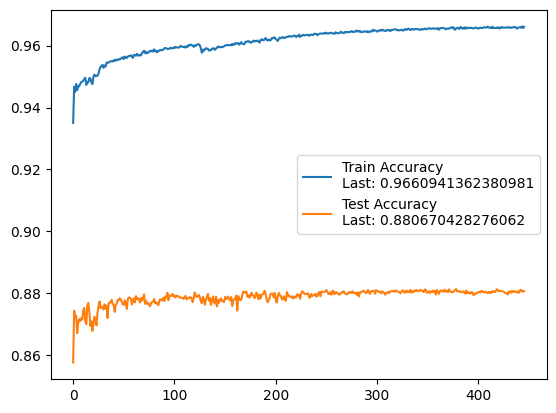

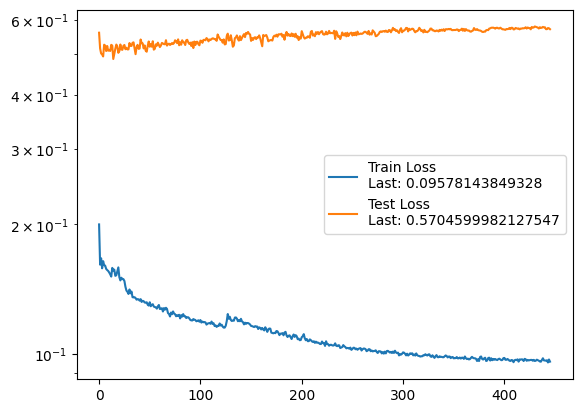

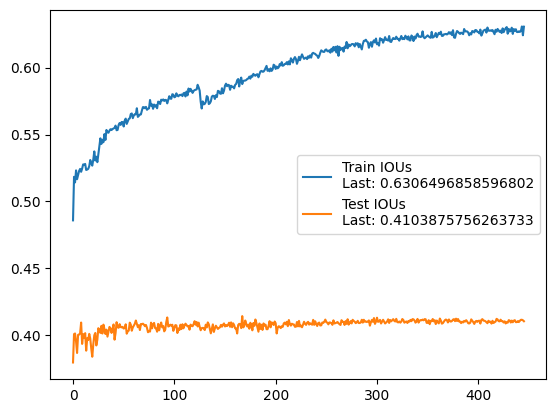

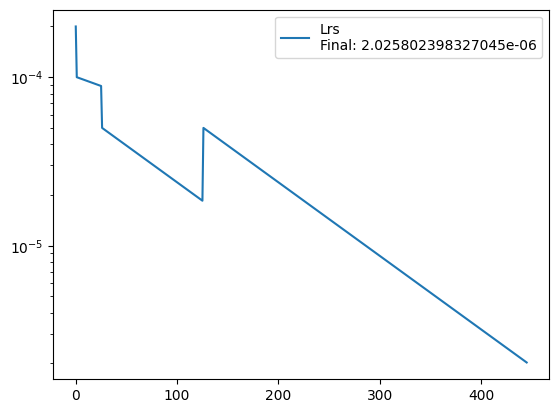

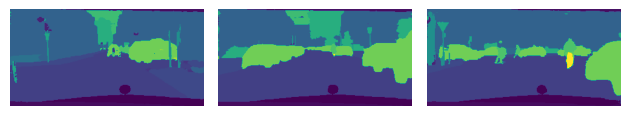


 =============== Epoch 696 ===============


100%|██████████| 186/186 [14:05<00:00,  4.54s/it]


 Train accuracy: 96.60881757736206%, Avg loss: 0.095760077198026, IOU: 62.91133761405945 lr: 2.0055443743437746e-06


100%|██████████| 32/32 [01:05<00:00,  2.04s/it]


 Test accuracy: 88.03632855415344%, Avg loss: 0.5724301491864026, IOU: 41.029420495033264

 =============== Epoch 697 ===============


100%|██████████| 186/186 [14:08<00:00,  4.56s/it]


 Train accuracy: 96.58929109573364%, Avg loss: 0.09657176716193076, IOU: 62.72324323654175 lr: 1.985488930600337e-06


100%|██████████| 32/32 [01:00<00:00,  1.91s/it]


 Test accuracy: 88.04095387458801%, Avg loss: 0.5728946048766375, IOU: 40.98507761955261

 =============== Epoch 698 ===============


100%|██████████| 186/186 [14:18<00:00,  4.62s/it]


 Train accuracy: 96.59531712532043%, Avg loss: 0.09617931624093363, IOU: 63.03722262382507 lr: 1.9656340412943334e-06


100%|██████████| 32/32 [01:02<00:00,  1.95s/it]


 Test accuracy: 88.03205490112305%, Avg loss: 0.5704138656146824, IOU: 40.98027944564819

 =============== Epoch 699 ===============


100%|██████████| 186/186 [14:14<00:00,  4.60s/it]


 Train accuracy: 96.60072922706604%, Avg loss: 0.09612682037135606, IOU: 62.88910508155823 lr: 1.94597770088139e-06


100%|██████████| 32/32 [00:58<00:00,  1.83s/it]


 Test accuracy: 88.0639910697937%, Avg loss: 0.5786247961223125, IOU: 41.122832894325256

 =============== Epoch 700 ===============


100%|██████████| 186/186 [14:06<00:00,  4.55s/it]


 Train accuracy: 96.58105373382568%, Avg loss: 0.09645440068937117, IOU: 62.86495327949524 lr: 1.926517923872576e-06


100%|██████████| 32/32 [01:00<00:00,  1.88s/it]


 Test accuracy: 87.94560432434082%, Avg loss: 0.5803001243621111, IOU: 41.01647436618805

 =============== Epoch 701 ===============


100%|██████████| 186/186 [14:09<00:00,  4.57s/it]


 Train accuracy: 96.61674499511719%, Avg loss: 0.09565523615287196, IOU: 62.91845440864563 lr: 1.9072527446338502e-06


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


 Test accuracy: 88.02776336669922%, Avg loss: 0.5695434561930597, IOU: 41.16295576095581

 =============== Epoch 702 ===============


100%|██████████| 186/186 [14:06<00:00,  4.55s/it]


 Train accuracy: 96.58902287483215%, Avg loss: 0.09615970386933255, IOU: 62.76288628578186 lr: 1.8881802171875118e-06


100%|██████████| 32/32 [01:01<00:00,  1.93s/it]


 Test accuracy: 88.04188966751099%, Avg loss: 0.5717707127332687, IOU: 41.028448939323425

 =============== Epoch 703 ===============


100%|██████████| 186/186 [14:15<00:00,  4.60s/it]


 Train accuracy: 96.60000205039978%, Avg loss: 0.09609132560510789, IOU: 62.66339421272278 lr: 1.8692984150156368e-06


100%|██████████| 32/32 [01:00<00:00,  1.88s/it]


 Test accuracy: 88.02629709243774%, Avg loss: 0.5749324066564441, IOU: 41.02563261985779

 =============== Epoch 704 ===============


100%|██████████| 186/186 [14:26<00:00,  4.66s/it]


 Train accuracy: 96.55957221984863%, Avg loss: 0.09727336678613899, IOU: 62.61855363845825 lr: 1.8506054308654804e-06


100%|██████████| 32/32 [01:07<00:00,  2.12s/it]


 Test accuracy: 88.0550742149353%, Avg loss: 0.5703695635311306, IOU: 40.964505076408386

 =============== Epoch 705 ===============


100%|██████████| 186/186 [14:16<00:00,  4.61s/it]


 Train accuracy: 96.60462141036987%, Avg loss: 0.09590227365173319, IOU: 62.82073259353638 lr: 1.8320993765568256e-06


100%|██████████| 32/32 [01:01<00:00,  1.92s/it]


 Test accuracy: 88.05745244026184%, Avg loss: 0.5750989345833659, IOU: 41.020211577415466
 Train accuracy: 96.6%, Avg loss: 0.095902, lr: 1.8320993765568256e-06
 Test accuracy: 88.1%, Avg loss: 0.575099


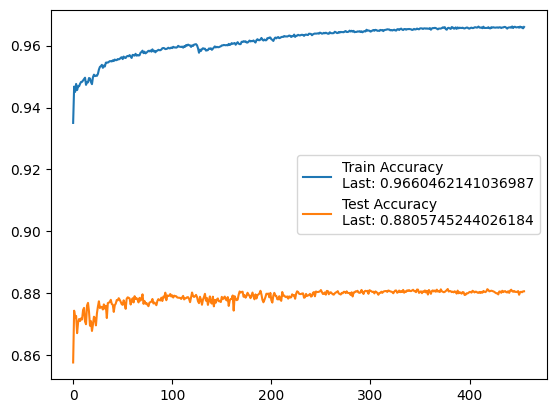

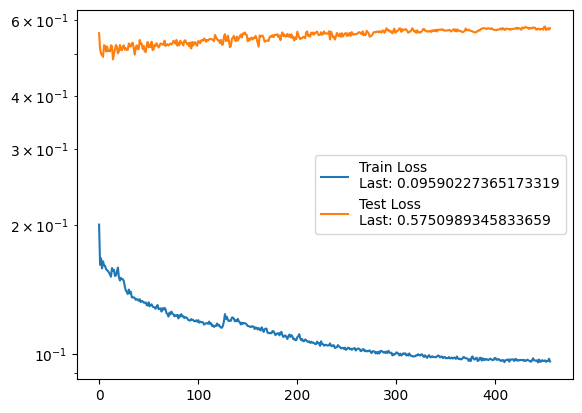

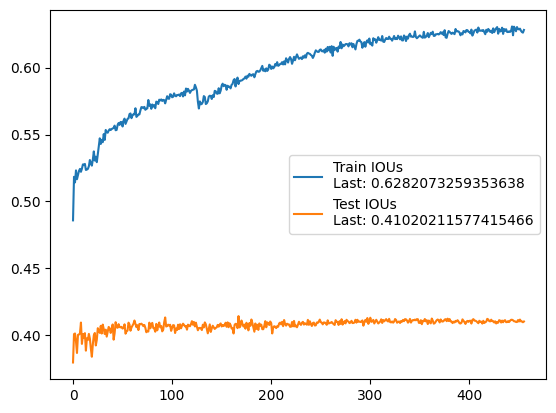

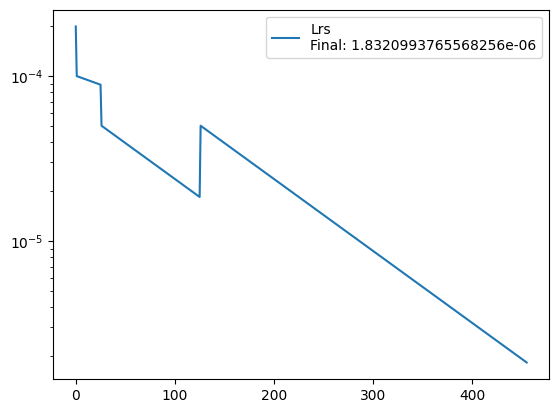

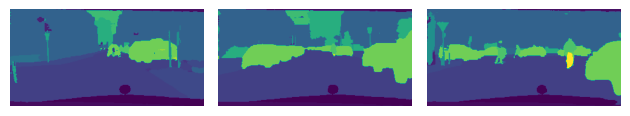


 =============== Epoch 706 ===============


100%|██████████| 186/186 [14:11<00:00,  4.58s/it]


 Train accuracy: 96.58907651901245%, Avg loss: 0.09647075647628435, IOU: 63.05813193321228 lr: 1.8137783827912573e-06


100%|██████████| 32/32 [01:09<00:00,  2.18s/it]


 Test accuracy: 88.03141713142395%, Avg loss: 0.5763253448531032, IOU: 40.958040952682495

 =============== Epoch 707 ===============


100%|██████████| 186/186 [14:16<00:00,  4.60s/it]


 Train accuracy: 96.59118056297302%, Avg loss: 0.09639546247099036, IOU: 63.19504380226135 lr: 1.7956405989633447e-06


100%|██████████| 32/32 [01:10<00:00,  2.21s/it]


 Test accuracy: 88.04348707199097%, Avg loss: 0.5711295721121132, IOU: 41.03640913963318

 =============== Epoch 708 ===============


100%|██████████| 186/186 [14:15<00:00,  4.60s/it]


 Train accuracy: 96.58830165863037%, Avg loss: 0.0962342619895935, IOU: 63.05311322212219 lr: 1.7776841929737112e-06


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


 Test accuracy: 88.05026412010193%, Avg loss: 0.5748110907152295, IOU: 40.97261726856232

 =============== Epoch 709 ===============


100%|██████████| 186/186 [13:18<00:00,  4.29s/it]


 Train accuracy: 96.60661816596985%, Avg loss: 0.09570927265030081, IOU: 63.16918134689331 lr: 1.759907351043974e-06


100%|██████████| 32/32 [01:00<00:00,  1.90s/it]


 Test accuracy: 88.02523016929626%, Avg loss: 0.5726109575480223, IOU: 40.92448651790619

 =============== Epoch 710 ===============


100%|██████████| 186/186 [13:08<00:00,  4.24s/it]


 Train accuracy: 96.60311341285706%, Avg loss: 0.09580936102617171, IOU: 63.09518814086914 lr: 1.7423082775335343e-06


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


 Test accuracy: 88.0340576171875%, Avg loss: 0.5731061473488808, IOU: 41.02580547332764

 =============== Epoch 711 ===============


100%|██████████| 186/186 [13:11<00:00,  4.26s/it]


 Train accuracy: 96.61632776260376%, Avg loss: 0.09551475273184878, IOU: 63.03873658180237 lr: 1.724885194758199e-06


100%|██████████| 32/32 [00:58<00:00,  1.81s/it]


 Test accuracy: 88.09695839881897%, Avg loss: 0.5764724928885698, IOU: 41.15804135799408

 =============== Epoch 712 ===============


100%|██████████| 186/186 [13:48<00:00,  4.45s/it]


 Train accuracy: 96.59909009933472%, Avg loss: 0.096035034425797, IOU: 62.72362470626831 lr: 1.707636342810617e-06


100%|██████████| 32/32 [01:02<00:00,  1.97s/it]


 Test accuracy: 88.05547952651978%, Avg loss: 0.5744777410291135, IOU: 41.00725054740906

 =============== Epoch 713 ===============


100%|██████████| 186/186 [13:17<00:00,  4.29s/it]


 Train accuracy: 96.59731388092041%, Avg loss: 0.09620790520021992, IOU: 62.760090827941895 lr: 1.6905599793825107e-06


100%|██████████| 32/32 [00:56<00:00,  1.76s/it]


 Test accuracy: 88.09035420417786%, Avg loss: 0.5713653136044741, IOU: 41.151052713394165

 =============== Epoch 714 ===============


100%|██████████| 186/186 [13:06<00:00,  4.23s/it]


 Train accuracy: 96.59116864204407%, Avg loss: 0.0963817263242378, IOU: 62.866026163101196 lr: 1.6736543795886855e-06


100%|██████████| 32/32 [00:59<00:00,  1.87s/it]


 Test accuracy: 88.0493700504303%, Avg loss: 0.573239148594439, IOU: 40.96202850341797

 =============== Epoch 715 ===============


100%|██████████| 186/186 [13:09<00:00,  4.24s/it]


 Train accuracy: 96.60032987594604%, Avg loss: 0.09600149988326975, IOU: 63.002532720565796 lr: 1.6569178357927987e-06


100%|██████████| 32/32 [00:59<00:00,  1.87s/it]


 Test accuracy: 88.08152675628662%, Avg loss: 0.5722377868369222, IOU: 40.995535254478455
 Train accuracy: 96.6%, Avg loss: 0.096001, lr: 1.6569178357927987e-06
 Test accuracy: 88.1%, Avg loss: 0.572238


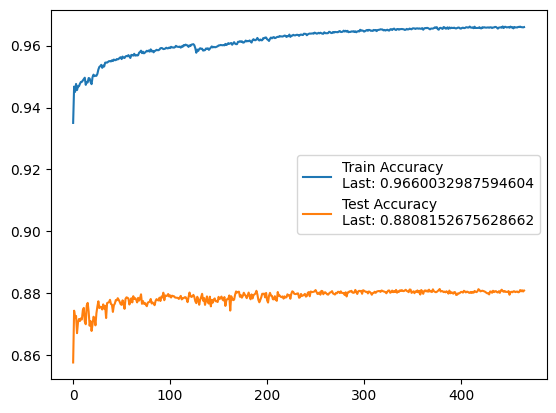

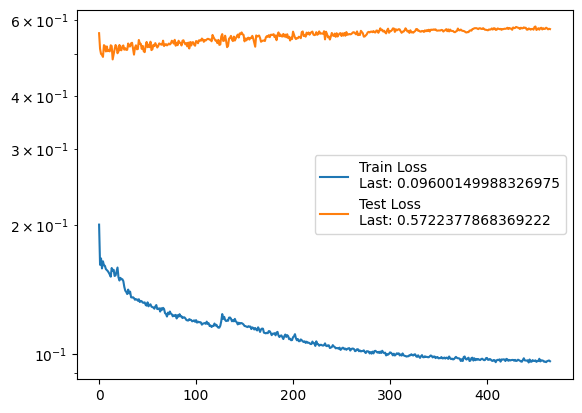

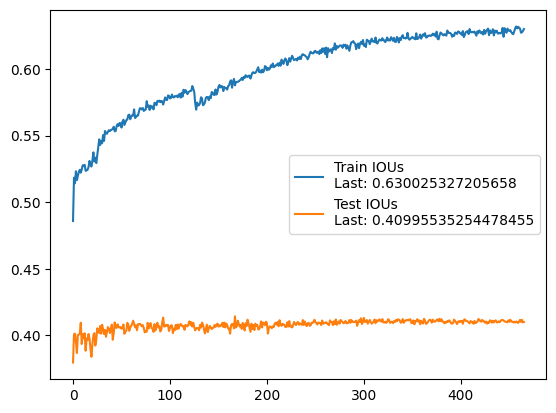

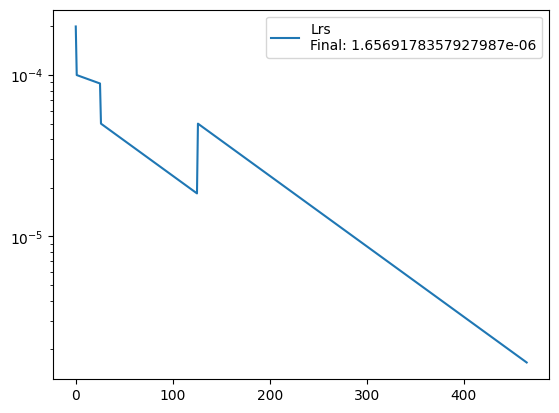

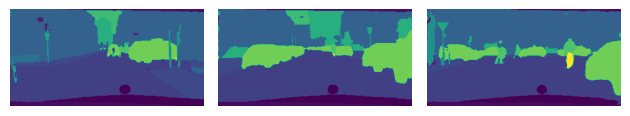


 =============== Epoch 716 ===============


100%|██████████| 186/186 [13:05<00:00,  4.22s/it]


 Train accuracy: 96.63459062576294%, Avg loss: 0.09498442549218414, IOU: 62.88253664970398 lr: 1.6403486574348707e-06


100%|██████████| 32/32 [01:00<00:00,  1.88s/it]


 Test accuracy: 88.04855942726135%, Avg loss: 0.5741858179681003, IOU: 40.92848300933838

 =============== Epoch 717 ===============


100%|██████████| 186/186 [13:21<00:00,  4.31s/it]


 Train accuracy: 96.60727977752686%, Avg loss: 0.09583148167979333, IOU: 62.839895486831665 lr: 1.623945170860522e-06


100%|██████████| 32/32 [00:58<00:00,  1.84s/it]


 Test accuracy: 88.04565668106079%, Avg loss: 0.5720360609702766, IOU: 40.8517986536026

 =============== Epoch 718 ===============


100%|██████████| 186/186 [13:11<00:00,  4.26s/it]


 Train accuracy: 96.585214138031%, Avg loss: 0.09638969007358757, IOU: 62.87688612937927 lr: 1.6077057191519166e-06


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


 Test accuracy: 88.06872963905334%, Avg loss: 0.5704536060802639, IOU: 40.945520997047424

 =============== Epoch 719 ===============


100%|██████████| 186/186 [13:11<00:00,  4.25s/it]


 Train accuracy: 96.59007787704468%, Avg loss: 0.09645403713308355, IOU: 62.598592042922974 lr: 1.5916286619603973e-06


100%|██████████| 32/32 [00:57<00:00,  1.80s/it]


 Test accuracy: 88.00448775291443%, Avg loss: 0.5733580598607659, IOU: 40.9691721200943

 =============== Epoch 720 ===============


100%|██████████| 186/186 [13:10<00:00,  4.25s/it]


 Train accuracy: 96.5754747390747%, Avg loss: 0.09673575291870742, IOU: 62.86758780479431 lr: 1.5757123753407934e-06


100%|██████████| 32/32 [01:01<00:00,  1.92s/it]


 Test accuracy: 88.06721568107605%, Avg loss: 0.5763423079624772, IOU: 41.14147126674652

 =============== Epoch 721 ===============


100%|██████████| 186/186 [13:16<00:00,  4.28s/it]


 Train accuracy: 96.58447504043579%, Avg loss: 0.09659869736561211, IOU: 62.83063292503357 lr: 1.5599552515873855e-06


100%|██████████| 32/32 [01:00<00:00,  1.88s/it]


 Test accuracy: 88.05431723594666%, Avg loss: 0.5756951947696507, IOU: 40.976500511169434

 =============== Epoch 722 ===============


100%|██████████| 186/186 [13:08<00:00,  4.24s/it]


 Train accuracy: 96.61217927932739%, Avg loss: 0.09560283493771347, IOU: 62.8842830657959 lr: 1.5443556990715115e-06


100%|██████████| 32/32 [01:00<00:00,  1.89s/it]


 Test accuracy: 88.0602478981018%, Avg loss: 0.5750145497731864, IOU: 41.01318717002869

 =============== Epoch 723 ===============


100%|██████████| 186/186 [13:28<00:00,  4.34s/it]


 Train accuracy: 96.58582210540771%, Avg loss: 0.09668056178157047, IOU: 62.68966794013977 lr: 1.5289121420807964e-06


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


 Test accuracy: 88.07314038276672%, Avg loss: 0.5759160588495433, IOU: 40.9828245639801

 =============== Epoch 724 ===============


100%|██████████| 186/186 [13:12<00:00,  4.26s/it]


 Train accuracy: 96.64135575294495%, Avg loss: 0.09489254581351433, IOU: 62.88192272186279 lr: 1.5136230206599885e-06


100%|██████████| 32/32 [00:59<00:00,  1.87s/it]


 Test accuracy: 88.05787563323975%, Avg loss: 0.5732579594478011, IOU: 41.01257622241974

 =============== Epoch 725 ===============


100%|██████████| 186/186 [13:15<00:00,  4.28s/it]


 Train accuracy: 96.61380648612976%, Avg loss: 0.095656643191012, IOU: 62.729841470718384 lr: 1.4984867904533886e-06


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


 Test accuracy: 88.02196383476257%, Avg loss: 0.5734858578070998, IOU: 40.82966148853302
 Train accuracy: 96.6%, Avg loss: 0.095657, lr: 1.4984867904533886e-06
 Test accuracy: 88.0%, Avg loss: 0.573486


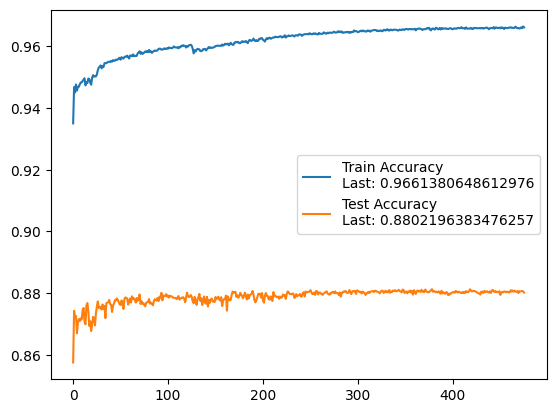

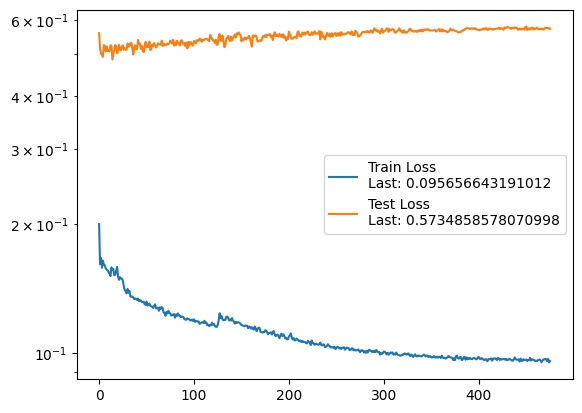

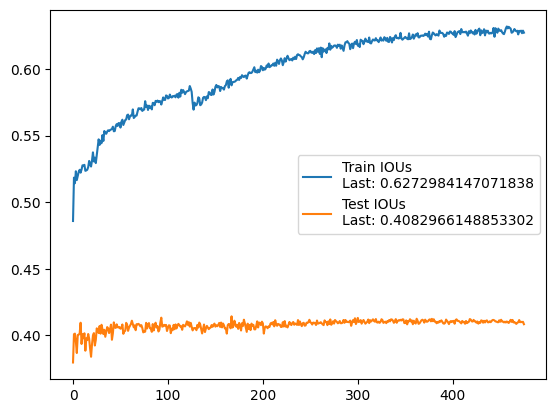

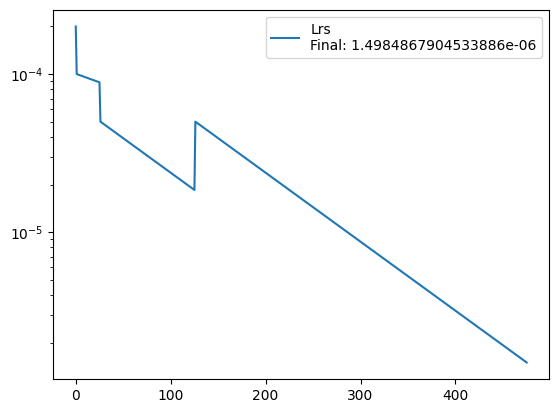

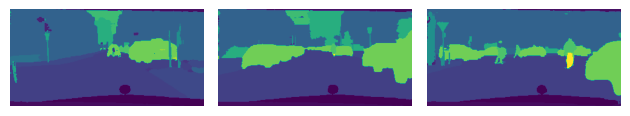


 =============== Epoch 726 ===============


100%|██████████| 186/186 [13:10<00:00,  4.25s/it]


 Train accuracy: 96.6024398803711%, Avg loss: 0.0961303264703802, IOU: 62.820255756378174 lr: 1.4835019225488547e-06


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


 Test accuracy: 88.06715607643127%, Avg loss: 0.5756657435558736, IOU: 40.95588028430939

 =============== Epoch 727 ===============


100%|██████████| 186/186 [13:14<00:00,  4.27s/it]


 Train accuracy: 96.5969979763031%, Avg loss: 0.09583597878615062, IOU: 62.84375190734863 lr: 1.4686669033233662e-06


100%|██████████| 32/32 [01:06<00:00,  2.09s/it]


 Test accuracy: 88.015615940094%, Avg loss: 0.5761684067547321, IOU: 40.9402459859848

 =============== Epoch 728 ===============


100%|██████████| 186/186 [13:19<00:00,  4.30s/it]


 Train accuracy: 96.6128408908844%, Avg loss: 0.09585001616067784, IOU: 62.74539828300476 lr: 1.4539802342901326e-06


100%|██████████| 32/32 [00:59<00:00,  1.87s/it]


 Test accuracy: 88.02748322486877%, Avg loss: 0.5729273878969252, IOU: 40.90661108493805

 =============== Epoch 729 ===============


100%|██████████| 186/186 [14:08<00:00,  4.56s/it]


 Train accuracy: 96.57754302024841%, Avg loss: 0.09665417430862304, IOU: 62.91707754135132 lr: 1.4394404319472312e-06


100%|██████████| 32/32 [01:02<00:00,  1.97s/it]


 Test accuracy: 88.03498148918152%, Avg loss: 0.5748491673730314, IOU: 41.007864475250244

 =============== Epoch 730 ===============


100%|██████████| 186/186 [14:10<00:00,  4.57s/it]


 Train accuracy: 96.59581184387207%, Avg loss: 0.096066419836334, IOU: 62.88422346115112 lr: 1.4250460276277589e-06


100%|██████████| 32/32 [01:08<00:00,  2.14s/it]


 Test accuracy: 88.06203007698059%, Avg loss: 0.5743551659397781, IOU: 41.048336029052734

 =============== Epoch 731 ===============


100%|██████████| 186/186 [14:15<00:00,  4.60s/it]


 Train accuracy: 96.61281704902649%, Avg loss: 0.09566229702003541, IOU: 62.87540793418884 lr: 1.4107955673514812e-06


100%|██████████| 32/32 [01:02<00:00,  1.96s/it]


 Test accuracy: 88.02831768989563%, Avg loss: 0.5717726927250624, IOU: 40.96740186214447

 =============== Epoch 732 ===============


100%|██████████| 186/186 [14:09<00:00,  4.57s/it]


 Train accuracy: 96.6238796710968%, Avg loss: 0.0952503317866915, IOU: 62.887316942214966 lr: 1.3966876116779664e-06


100%|██████████| 32/32 [00:58<00:00,  1.83s/it]


 Test accuracy: 88.0586326122284%, Avg loss: 0.5752174947410822, IOU: 40.94468653202057

 =============== Epoch 733 ===============


100%|██████████| 186/186 [14:06<00:00,  4.55s/it]


 Train accuracy: 96.58857583999634%, Avg loss: 0.09642313641085419, IOU: 62.84862756729126 lr: 1.3827207355611867e-06


100%|██████████| 32/32 [01:03<00:00,  1.99s/it]


 Test accuracy: 88.02746534347534%, Avg loss: 0.5783829428255558, IOU: 40.958088636398315

 =============== Epoch 734 ===============


100%|██████████| 186/186 [13:03<00:00,  4.21s/it]


 Train accuracy: 96.60215377807617%, Avg loss: 0.09578529573095743, IOU: 63.00790309906006 lr: 1.3688935282055749e-06


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


 Test accuracy: 88.05019855499268%, Avg loss: 0.5753128761425614, IOU: 41.01995229721069

 =============== Epoch 735 ===============


100%|██████████| 186/186 [13:07<00:00,  4.23s/it]


 Train accuracy: 96.61948680877686%, Avg loss: 0.09528106723421363, IOU: 62.9957914352417 lr: 1.355204592923519e-06


100%|██████████| 32/32 [00:58<00:00,  1.83s/it]


 Test accuracy: 88.0751371383667%, Avg loss: 0.5771170118823647, IOU: 40.97679257392883
 Train accuracy: 96.6%, Avg loss: 0.095281, lr: 1.355204592923519e-06
 Test accuracy: 88.1%, Avg loss: 0.577117


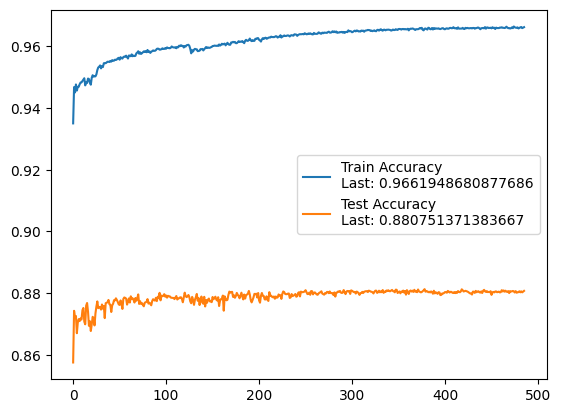

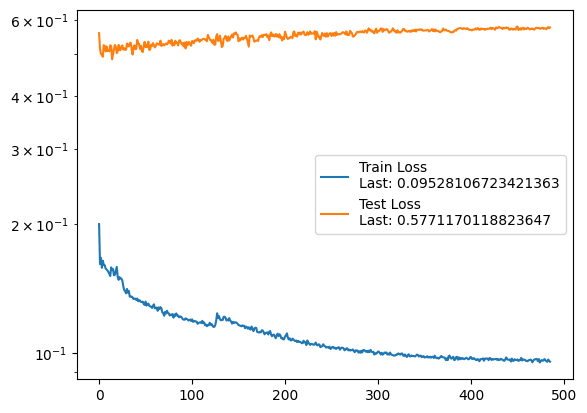

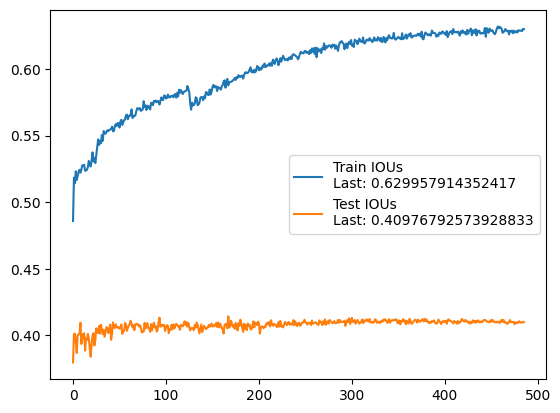

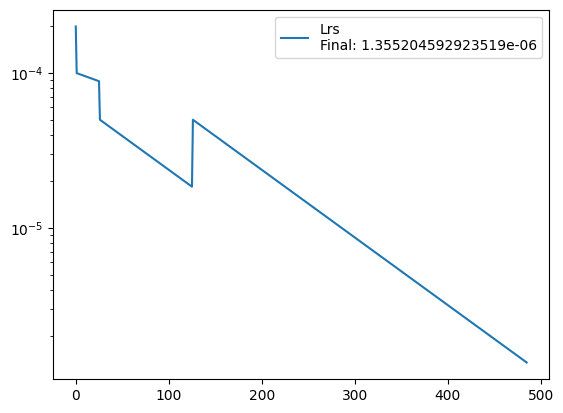

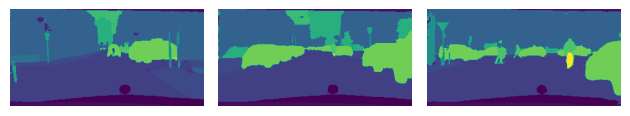


 =============== Epoch 736 ===============


100%|██████████| 186/186 [13:01<00:00,  4.20s/it]


 Train accuracy: 96.5962827205658%, Avg loss: 0.09595359172872318, IOU: 63.083332777023315 lr: 1.341652546994284e-06


100%|██████████| 32/32 [00:58<00:00,  1.83s/it]


 Test accuracy: 88.0426287651062%, Avg loss: 0.5776357632130384, IOU: 40.93676805496216

 =============== Epoch 737 ===============


100%|██████████| 186/186 [13:11<00:00,  4.25s/it]


 Train accuracy: 96.58085107803345%, Avg loss: 0.09654701981813676, IOU: 62.810707092285156 lr: 1.328236021524341e-06


100%|██████████| 32/32 [00:57<00:00,  1.81s/it]


 Test accuracy: 88.07224631309509%, Avg loss: 0.5719275628216565, IOU: 41.032999753952026

 =============== Epoch 738 ===============


100%|██████████| 186/186 [13:14<00:00,  4.27s/it]


 Train accuracy: 96.59338593482971%, Avg loss: 0.09606274637964464, IOU: 62.9295289516449 lr: 1.3149536613090976e-06


100%|██████████| 32/32 [01:05<00:00,  2.04s/it]


 Test accuracy: 88.1165623664856%, Avg loss: 0.5743840653449297, IOU: 41.200605034828186

 =============== Epoch 739 ===============


100%|██████████| 186/186 [14:19<00:00,  4.62s/it]


 Train accuracy: 96.61890864372253%, Avg loss: 0.0952916836305972, IOU: 63.096994161605835 lr: 1.3018041246960067e-06


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


 Test accuracy: 88.04526329040527%, Avg loss: 0.5745484572835267, IOU: 40.87763726711273

 =============== Epoch 740 ===============


100%|██████████| 186/186 [13:15<00:00,  4.27s/it]


 Train accuracy: 96.6201901435852%, Avg loss: 0.09539329252576315, IOU: 62.98498511314392 lr: 1.2887860834490465e-06


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


 Test accuracy: 88.08626532554626%, Avg loss: 0.5729571436531842, IOU: 40.953853726387024

 =============== Epoch 741 ===============


100%|██████████| 186/186 [13:19<00:00,  4.30s/it]


 Train accuracy: 96.62203788757324%, Avg loss: 0.09501736823429344, IOU: 63.00445199012756 lr: 1.2758982226145561e-06


100%|██████████| 32/32 [01:07<00:00,  2.11s/it]


 Test accuracy: 88.09959888458252%, Avg loss: 0.5750903803855181, IOU: 41.19413495063782

 =============== Epoch 742 ===============


100%|██████████| 186/186 [13:25<00:00,  4.33s/it]


 Train accuracy: 96.60027623176575%, Avg loss: 0.09590877312165434, IOU: 62.96780705451965 lr: 1.2631392403884106e-06


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


 Test accuracy: 88.03716897964478%, Avg loss: 0.5728350491262972, IOU: 40.969520807266235

 =============== Epoch 743 ===============


100%|██████████| 186/186 [13:18<00:00,  4.29s/it]


 Train accuracy: 96.58030867576599%, Avg loss: 0.09666807108348416, IOU: 62.799447774887085 lr: 1.2505078479845264e-06


100%|██████████| 32/32 [00:57<00:00,  1.79s/it]


 Test accuracy: 88.04049491882324%, Avg loss: 0.5739488061517477, IOU: 40.929535031318665

 =============== Epoch 744 ===============


100%|██████████| 186/186 [13:13<00:00,  4.27s/it]


 Train accuracy: 96.62243127822876%, Avg loss: 0.09529521696830309, IOU: 62.903839349746704 lr: 1.2380027695046811e-06


100%|██████████| 32/32 [00:58<00:00,  1.82s/it]


 Test accuracy: 88.08303475379944%, Avg loss: 0.5732589163817465, IOU: 41.037148237228394

 =============== Epoch 745 ===============


100%|██████████| 186/186 [13:11<00:00,  4.26s/it]


 Train accuracy: 96.64091467857361%, Avg loss: 0.09478715378590809, IOU: 63.02627921104431 lr: 1.2256227418096343e-06


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


 Test accuracy: 88.07407021522522%, Avg loss: 0.5756936287507415, IOU: 40.98334610462189
 Train accuracy: 96.6%, Avg loss: 0.094787, lr: 1.2256227418096343e-06
 Test accuracy: 88.1%, Avg loss: 0.575694


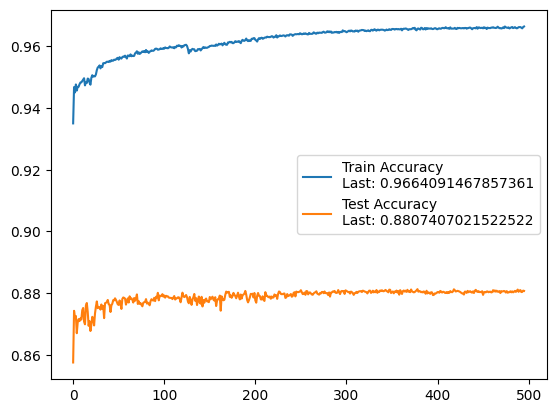

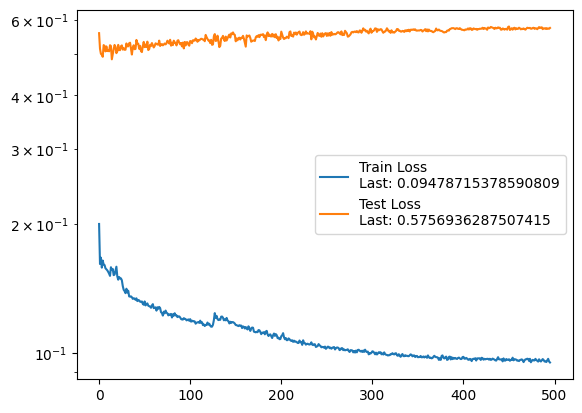

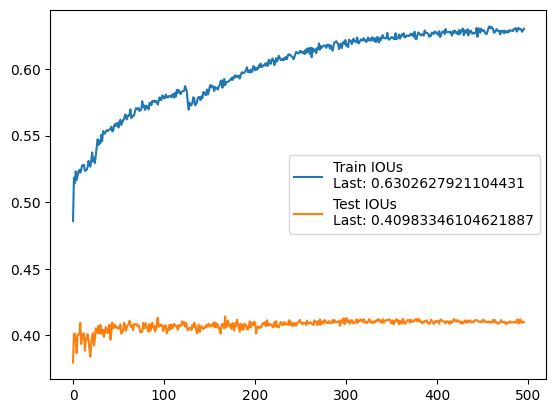

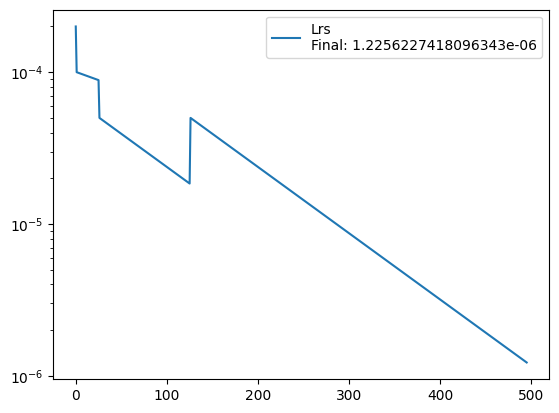

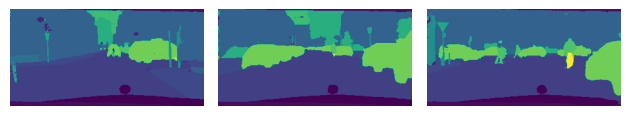


 =============== Epoch 746 ===============


100%|██████████| 186/186 [13:13<00:00,  4.27s/it]


 Train accuracy: 96.61508798599243%, Avg loss: 0.09554342893503046, IOU: 63.058292865753174 lr: 1.213366514391538e-06


100%|██████████| 32/32 [00:59<00:00,  1.87s/it]


 Test accuracy: 88.08808922767639%, Avg loss: 0.5772131099365652, IOU: 41.13152623176575

 =============== Epoch 747 ===============


100%|██████████| 186/186 [13:16<00:00,  4.28s/it]


 Train accuracy: 96.6096043586731%, Avg loss: 0.09583513390633368, IOU: 62.8928005695343 lr: 1.2012328492476225e-06


100%|██████████| 32/32 [00:59<00:00,  1.87s/it]


 Test accuracy: 88.06414008140564%, Avg loss: 0.575867862906307, IOU: 41.19820296764374

 =============== Epoch 748 ===============


100%|██████████| 186/186 [13:25<00:00,  4.33s/it]


 Train accuracy: 96.61312103271484%, Avg loss: 0.09561981384952863, IOU: 62.973469495773315 lr: 1.1892205207551463e-06


100%|██████████| 32/32 [00:57<00:00,  1.81s/it]


 Test accuracy: 88.05205821990967%, Avg loss: 0.5744004705920815, IOU: 40.96944034099579

 =============== Epoch 749 ===============


100%|██████████| 186/186 [13:15<00:00,  4.28s/it]


 Train accuracy: 96.57394289970398%, Avg loss: 0.09690894739281747, IOU: 62.99435496330261 lr: 1.1773283155475948e-06


100%|██████████| 32/32 [00:57<00:00,  1.78s/it]


 Test accuracy: 88.06102275848389%, Avg loss: 0.5763202449306846, IOU: 41.05186462402344

 =============== Epoch 750 ===============


100%|██████████| 186/186 [13:16<00:00,  4.28s/it]


 Train accuracy: 96.61107659339905%, Avg loss: 0.09562922966095709, IOU: 62.98689842224121 lr: 1.165555032392119e-06


100%|██████████| 32/32 [00:59<00:00,  1.86s/it]


 Test accuracy: 88.03651332855225%, Avg loss: 0.5754512716084719, IOU: 40.965333580970764

 =============== Epoch 751 ===============


100%|██████████| 186/186 [13:14<00:00,  4.27s/it]


 Train accuracy: 96.62644267082214%, Avg loss: 0.0953632843510438, IOU: 62.94957995414734 lr: 1.1538994820681977e-06


100%|██████████| 32/32 [01:00<00:00,  1.88s/it]


 Test accuracy: 88.03912401199341%, Avg loss: 0.5743687143549323, IOU: 41.06285274028778

 =============== Epoch 752 ===============


100%|██████████| 186/186 [13:17<00:00,  4.29s/it]


 Train accuracy: 96.58532738685608%, Avg loss: 0.09649852026374109, IOU: 62.85020709037781 lr: 1.1423604872475157e-06


100%|██████████| 32/32 [01:00<00:00,  1.88s/it]


 Test accuracy: 88.02611231803894%, Avg loss: 0.5785391824319959, IOU: 41.083329916000366

 =============== Epoch 753 ===============


100%|██████████| 186/186 [13:22<00:00,  4.31s/it]


 Train accuracy: 96.60463333129883%, Avg loss: 0.09568898800399996, IOU: 62.94127106666565 lr: 1.1309368823750406e-06


100%|██████████| 32/32 [01:06<00:00,  2.07s/it]


 Test accuracy: 88.00783157348633%, Avg loss: 0.5745033635757864, IOU: 41.05018675327301

 =============== Epoch 754 ===============


100%|██████████| 186/186 [14:32<00:00,  4.69s/it]


 Train accuracy: 96.60642147064209%, Avg loss: 0.09580618832060085, IOU: 62.99886703491211 lr: 1.1196275135512901e-06


100%|██████████| 32/32 [01:01<00:00,  1.92s/it]


 Test accuracy: 88.00724148750305%, Avg loss: 0.5730949868448079, IOU: 41.07992351055145

 =============== Epoch 755 ===============


100%|██████████| 186/186 [14:13<00:00,  4.59s/it]


 Train accuracy: 96.60711288452148%, Avg loss: 0.09577286660030324, IOU: 62.72193193435669 lr: 1.1084312384157772e-06


100%|██████████| 32/32 [01:01<00:00,  1.91s/it]


 Test accuracy: 88.03017735481262%, Avg loss: 0.5782269462943077, IOU: 41.03028476238251
 Train accuracy: 96.6%, Avg loss: 0.095773, lr: 1.1084312384157772e-06
 Test accuracy: 88.0%, Avg loss: 0.578227


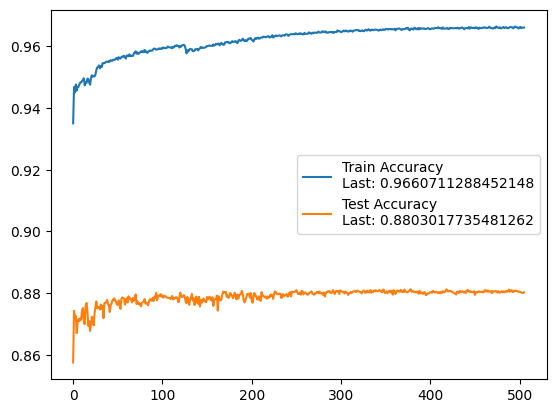

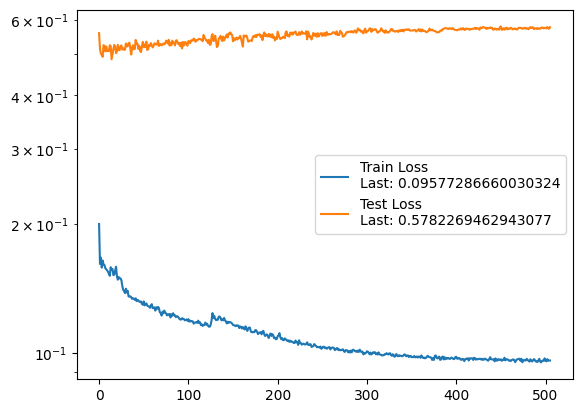

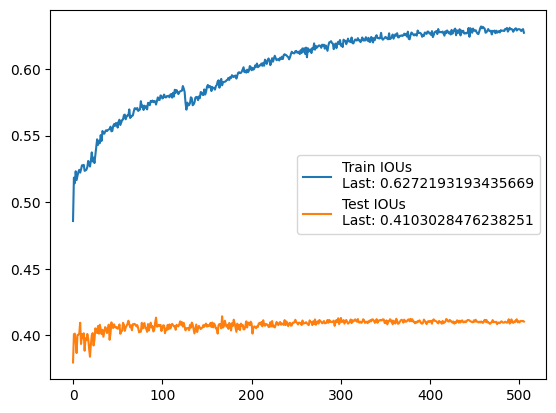

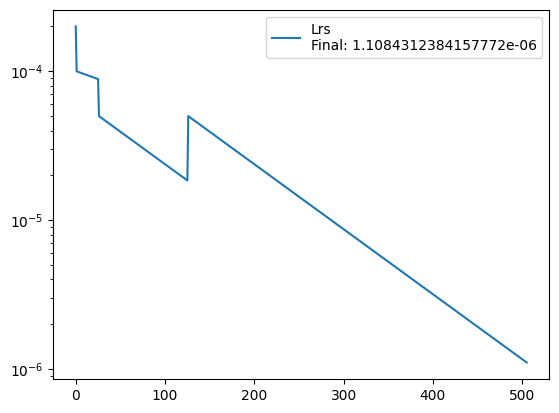

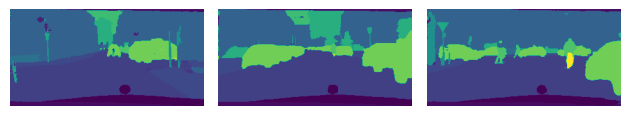


 =============== Epoch 756 ===============


100%|██████████| 186/186 [14:22<00:00,  4.63s/it]


 Train accuracy: 96.60970568656921%, Avg loss: 0.09587364932221751, IOU: 63.061851263046265 lr: 1.0973469260316194e-06


100%|██████████| 32/32 [01:00<00:00,  1.90s/it]


 Test accuracy: 88.04604411125183%, Avg loss: 0.574219177942723, IOU: 40.880024433135986

 =============== Epoch 757 ===============


100%|██████████| 186/186 [14:36<00:00,  4.71s/it]


 Train accuracy: 96.59780859947205%, Avg loss: 0.096016790437442, IOU: 62.73014545440674 lr: 1.086373456771303e-06


100%|██████████| 32/32 [01:08<00:00,  2.13s/it]


 Test accuracy: 88.04199695587158%, Avg loss: 0.5772534930147231, IOU: 40.958982706069946

 =============== Epoch 758 ===============


100%|██████████| 186/186 [14:31<00:00,  4.68s/it]


 Train accuracy: 96.59542441368103%, Avg loss: 0.0961689883742922, IOU: 63.1462037563324 lr: 1.0755097222035901e-06


100%|██████████| 32/32 [01:01<00:00,  1.92s/it]


 Test accuracy: 88.03426623344421%, Avg loss: 0.5772220990620553, IOU: 41.055890917778015

 =============== Epoch 759 ===============


100%|██████████| 186/186 [14:25<00:00,  4.66s/it]


 Train accuracy: 96.59844636917114%, Avg loss: 0.09607841479041243, IOU: 62.737393379211426 lr: 1.0647546249815542e-06


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


 Test accuracy: 88.03386688232422%, Avg loss: 0.5761413616128266, IOU: 41.01283848285675

 =============== Epoch 760 ===============


100%|██████████| 186/186 [14:41<00:00,  4.74s/it]


 Train accuracy: 96.59098982810974%, Avg loss: 0.09622087053233577, IOU: 62.9967987537384 lr: 1.0541070787317387e-06


100%|██████████| 32/32 [01:02<00:00,  1.95s/it]


 Test accuracy: 88.04893493652344%, Avg loss: 0.5769852031953633, IOU: 40.92330038547516

 =============== Epoch 761 ===============


100%|██████████| 186/186 [14:28<00:00,  4.67s/it]


 Train accuracy: 96.62257432937622%, Avg loss: 0.0955095156546562, IOU: 63.04791569709778 lr: 1.0435660079444213e-06


100%|██████████| 32/32 [01:02<00:00,  1.97s/it]


 Test accuracy: 88.03854584693909%, Avg loss: 0.5766769936308265, IOU: 40.928491950035095

 =============== Epoch 762 ===============


100%|██████████| 186/186 [14:23<00:00,  4.64s/it]


 Train accuracy: 96.59398198127747%, Avg loss: 0.09637853427119153, IOU: 62.74663209915161 lr: 1.033130347864977e-06


100%|██████████| 32/32 [01:00<00:00,  1.90s/it]


 Test accuracy: 88.03666830062866%, Avg loss: 0.5763150062412024, IOU: 40.875160694122314

 =============== Epoch 763 ===============


100%|██████████| 186/186 [14:37<00:00,  4.72s/it]


 Train accuracy: 96.61710262298584%, Avg loss: 0.09548147074798102, IOU: 63.0035400390625 lr: 1.0227990443863274e-06


100%|██████████| 32/32 [01:00<00:00,  1.89s/it]


 Test accuracy: 88.06348443031311%, Avg loss: 0.5734644941985607, IOU: 40.998485684394836

 =============== Epoch 764 ===============


100%|██████████| 186/186 [14:34<00:00,  4.70s/it]


 Train accuracy: 96.62967920303345%, Avg loss: 0.09523962285890374, IOU: 63.01218867301941 lr: 1.012571053942464e-06


100%|██████████| 32/32 [01:02<00:00,  1.96s/it]


 Test accuracy: 88.007652759552%, Avg loss: 0.5812008860521019, IOU: 40.88250398635864

 =============== Epoch 765 ===============


100%|██████████| 186/186 [14:24<00:00,  4.65s/it]


 Train accuracy: 96.62982225418091%, Avg loss: 0.09532632622667538, IOU: 63.08435797691345 lr: 1.0024453434030394e-06


100%|██████████| 32/32 [01:00<00:00,  1.88s/it]


 Test accuracy: 88.04475665092468%, Avg loss: 0.5759900659322739, IOU: 40.958136320114136
 Train accuracy: 96.6%, Avg loss: 0.095326, lr: 1.0024453434030394e-06
 Test accuracy: 88.0%, Avg loss: 0.575990


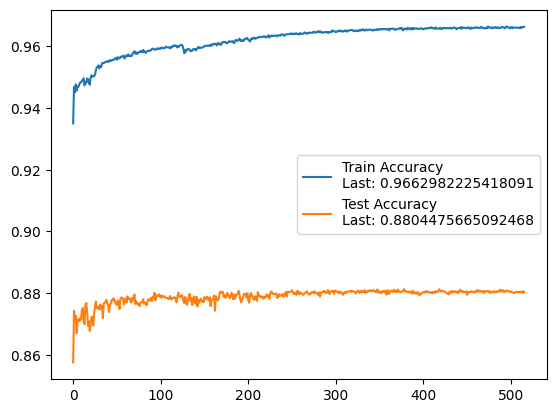

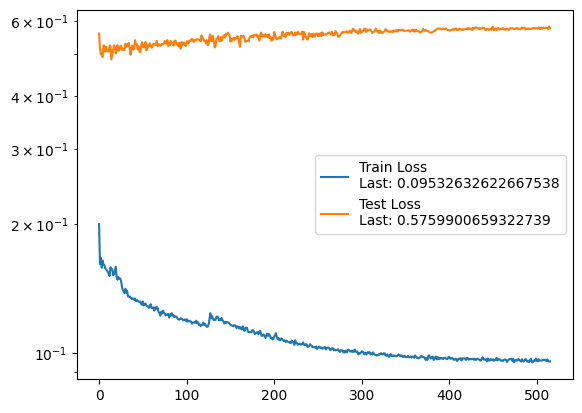

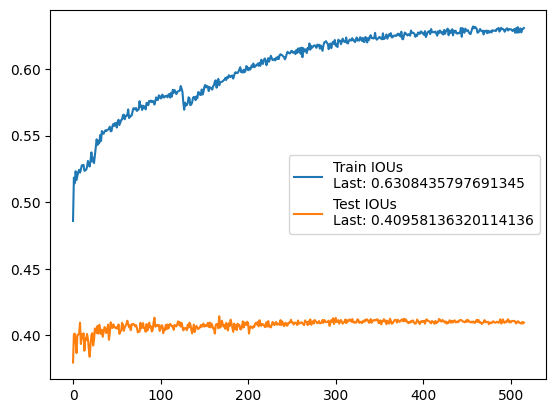

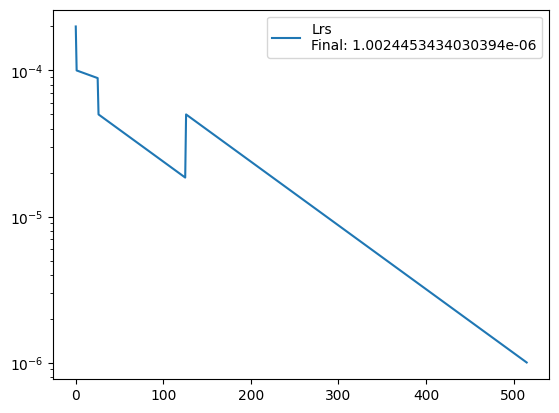

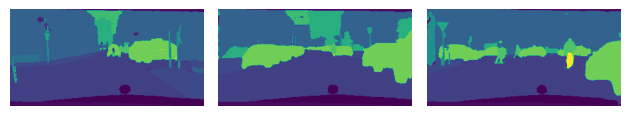


 =============== Epoch 766 ===============


100%|██████████| 186/186 [14:18<00:00,  4.62s/it]


 Train accuracy: 96.59968614578247%, Avg loss: 0.09588104863000173, IOU: 63.13365697860718 lr: 9.92420889969009e-07


100%|██████████| 32/32 [01:01<00:00,  1.93s/it]


 Test accuracy: 87.98484206199646%, Avg loss: 0.5780389793217182, IOU: 40.95006287097931

 =============== Epoch 767 ===============


100%|██████████| 186/186 [13:59<00:00,  4.51s/it]


 Train accuracy: 96.60894274711609%, Avg loss: 0.0953265135727262, IOU: 62.84329891204834 lr: 9.824966810693189e-07


100%|██████████| 32/32 [00:59<00:00,  1.85s/it]


 Test accuracy: 88.04860711097717%, Avg loss: 0.5773407057859004, IOU: 41.02098345756531

 =============== Epoch 768 ===============


100%|██████████| 186/186 [13:19<00:00,  4.30s/it]


 Train accuracy: 96.60807847976685%, Avg loss: 0.09577469311414226, IOU: 63.082289695739746 lr: 9.726717142586257e-07


100%|██████████| 32/32 [01:00<00:00,  1.89s/it]


 Test accuracy: 88.04540634155273%, Avg loss: 0.5813077823258936, IOU: 40.99402725696564

 =============== Epoch 769 ===============


100%|██████████| 186/186 [13:20<00:00,  4.30s/it]


 Train accuracy: 96.60660028457642%, Avg loss: 0.09573456524841246, IOU: 63.04762363433838 lr: 9.629449971160395e-07


100%|██████████| 32/32 [01:00<00:00,  1.91s/it]


 Test accuracy: 88.0469799041748%, Avg loss: 0.5777859385125339, IOU: 40.98665118217468

 =============== Epoch 770 ===============


100%|██████████| 186/186 [13:19<00:00,  4.30s/it]


 Train accuracy: 96.62187099456787%, Avg loss: 0.0952679309793698, IOU: 63.2183313369751 lr: 9.533155471448791e-07


100%|██████████| 32/32 [00:58<00:00,  1.83s/it]


 Test accuracy: 88.02889585494995%, Avg loss: 0.5786687564104795, IOU: 40.97221493721008

 =============== Epoch 771 ===============


100%|██████████| 186/186 [13:50<00:00,  4.47s/it]


 Train accuracy: 96.60360813140869%, Avg loss: 0.095905587357539, IOU: 62.725770473480225 lr: 9.437823916734303e-07


100%|██████████| 32/32 [01:10<00:00,  2.20s/it]


 Test accuracy: 88.06284070014954%, Avg loss: 0.5782269686460495, IOU: 40.88856875896454

 =============== Epoch 772 ===============


100%|██████████| 186/186 [13:38<00:00,  4.40s/it]


 Train accuracy: 96.61378264427185%, Avg loss: 0.0956199508440751, IOU: 63.068556785583496 lr: 9.34344567756696e-07


100%|██████████| 32/32 [01:00<00:00,  1.88s/it]


 Test accuracy: 88.04228901863098%, Avg loss: 0.5739752198569477, IOU: 41.03961884975433

 =============== Epoch 773 ===============


100%|██████████| 186/186 [14:38<00:00,  4.72s/it]


 Train accuracy: 96.60977125167847%, Avg loss: 0.09568786653139258, IOU: 63.07748556137085 lr: 9.250011220791291e-07


100%|██████████| 32/32 [01:02<00:00,  1.94s/it]


 Test accuracy: 88.07257413864136%, Avg loss: 0.5769144156947732, IOU: 41.19171500205994

 =============== Epoch 774 ===============


100%|██████████| 186/186 [14:32<00:00,  4.69s/it]


 Train accuracy: 96.6298758983612%, Avg loss: 0.09526386360327403, IOU: 63.18204998970032 lr: 9.157511108583377e-07


100%|██████████| 32/32 [01:02<00:00,  1.94s/it]


 Test accuracy: 88.04041743278503%, Avg loss: 0.5741483634337783, IOU: 41.01799428462982

 =============== Epoch 775 ===============


100%|██████████| 186/186 [14:22<00:00,  4.64s/it]


 Train accuracy: 96.60651683807373%, Avg loss: 0.09562327720785654, IOU: 62.87599205970764 lr: 9.065935997497544e-07


100%|██████████| 32/32 [01:02<00:00,  1.95s/it]


 Test accuracy: 88.0380392074585%, Avg loss: 0.5776208071038127, IOU: 41.03754460811615
 Train accuracy: 96.6%, Avg loss: 0.095623, lr: 9.065935997497544e-07
 Test accuracy: 88.0%, Avg loss: 0.577621


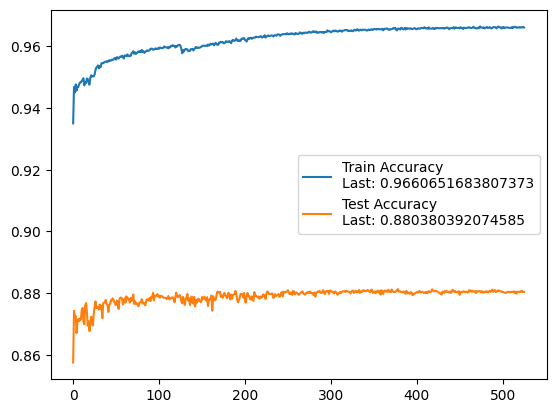

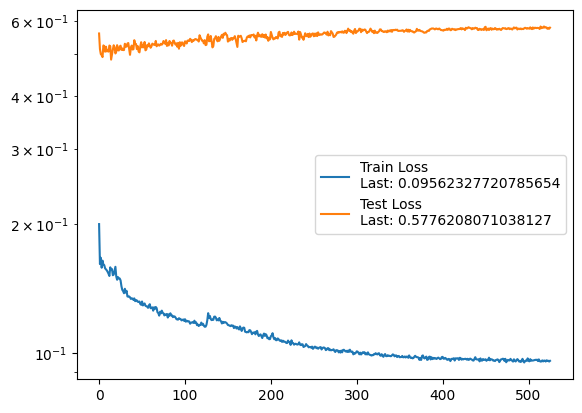

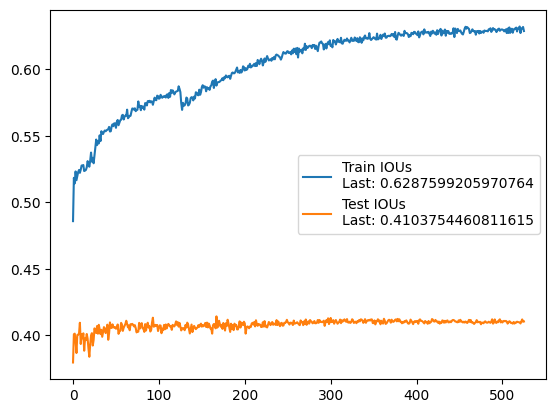

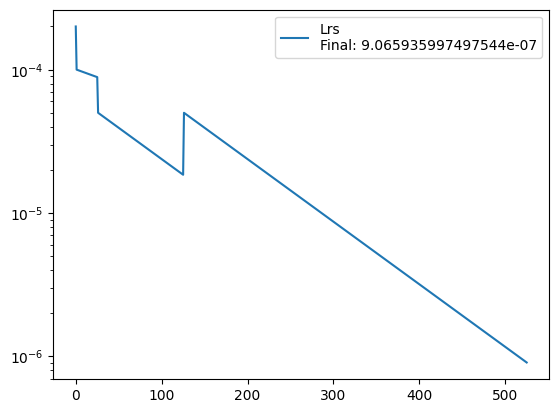

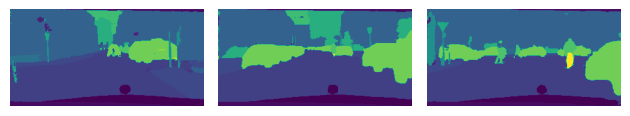

In [133]:
for i in range(NUM_EPOCHS//NUM_EPOCHS_TO_SAVE):
    train_(epochs=NUM_EPOCHS_TO_SAVE, inner_log=INNER_LOG_DISPLAY)
    STORE_PATH = save(os.path.join(str(TRAIN_ID), f'{epoch}'), model, training_accuracy, training_losses, validation_accuracy, validation_losses, lrs)
    plot(STORE_PATH)
    imshow_test(model, val_loader, device, show_reference=False, show_original=False, colorbar=False, softmax=True)AX